# Pardis Zandkarimi - 810101081
CA 05 - phase 1


# MLP from scratch

In this homework, you will code a [Multilayer perceptron](https://en.wikipedia.org/wiki/Multilayer_perceptron) with one hidden layer to classify text data.

Advice:
- As much as possible, please try to make matrix and vector operations (good practice for efficient code)
- If you're not familiar with numpy, check the documentation of `np.max`, `np.clip`, `np.random.randn`, `np.reshape`. FYI the matrix multiplication operator is `@`, and you may want to learn about [broadcasting rules](https://numpy.org/doc/stable/user/basics.broadcasting.html) to see how it deals with tensor operations of different sizes
- You can also check about `torch.clamp`, `torch.nn.Parameter`

## 1. Some utilities and dataset for Part 2

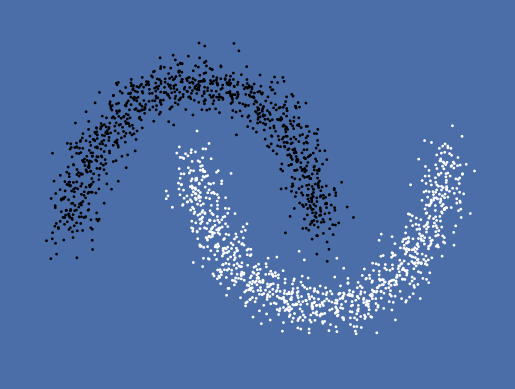

In [200]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import copy

# Plot the dataset
def plot_data(ax, X, Y):
    plt.axis('off')
    ax.scatter(X[:, 0], X[:, 1], s=1, c=Y, cmap='bone')

from sklearn.datasets import make_moons
#Generate dataset X and corresponding labels Y.
X, Y = make_moons(n_samples=2000, noise=0.1)

%matplotlib inline
x_min, x_max = -1.5, 2.5
y_min, y_max = -1, 1.5
fig, ax = plt.subplots(1, 1, facecolor='#4B6EA9')
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
plot_data(ax, X, Y)
plt.show()

In [201]:
# Define the grid on which we will evaluate our classifier
xx, yy = np.meshgrid(np.arange(x_min, x_max, .1),
                     np.arange(y_min, y_max, .1))

to_forward = np.array(list(zip(xx.ravel(), yy.ravel())))

# plot the decision boundary of our classifier
def plot_decision_boundary(ax, X, Y, classifier):
    # forward pass on the grid, then convert to numpy for plotting
  
    Z = classifier.forward(to_forward)
    Z = Z.reshape(xx.shape)
    
    # plot contour lines of the values of our classifier on the grid
    ax.contourf(xx, yy, Z>0.5, cmap='Blues')
    
    # then plot the dataset
    plot_data(ax, X,Y)

## 2. MLP in numpy

Here you need to code your implementation of the [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) activation and the [Sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function).

In [202]:
class MyReLU(object):
    def forward(self, x):
        # the relu is y_i = max(0, x_i)
        self.output = np.maximum(0, x)
        return self.output
    
    def backward(self, grad_output):
        # the gradient is 1 for the inputs that were above 0, 0 elsewhere
        relu_grad = np.where(self.output > 0, 1, 0)
        # relu_grad = (self.output > 0).astype(float)
        grad_input = grad_output * relu_grad
        return grad_input
    
    def step(self, learning_rate):
        # no need to do anything here, since ReLU has no parameters
        return

class MySigmoid(object):
    def forward(self, x):
        self.x = x
        # the sigmoid is y_i = 1./(1+exp(-x_i))
        self.output = 1. / (1. + np.exp(-x))
        return 1. / (1. + np.exp(-x))
    
    def backward(self, grad_output):
        # the partial derivative is e^-x / (e^-x + 1)^2
        return grad_output * self.output * (1-self.output)
    
    def step(self, learning_rate):
        # no need to do anything here since Sigmoid has no parameters
        return


Probably a good time to test your functions...

In [203]:
test_relu = MyReLU()
test_relu.forward([0, -1, 0.5, -0.5, 0.8, 1])

array([0. , 0. , 0.5, 0. , 0.8, 1. ])

In [204]:
test_relu.backward(np.ones(1))

array([0., 0., 1., 0., 1., 1.])

In [205]:
test_sig = MySigmoid()

test_sig.forward(np.ones(1))

array([0.73105858])

In [206]:
test_sig.backward(np.ones(1))

array([0.19661193])

A bit more complicated, you need now to implement your linear layer i.e. multiplication by a matrix W and summing with a bias b.

In [207]:
class MyLinear(object):
    def __init__(self, n_input, n_output):
        # initialize two random matrices for W and b (use np.random.randn)
        self.W = np.random.randn(n_input, n_output) 
        self.b = np.random.randn(n_output)

    def forward(self, x):
        # save a copy of x, you'll need it for the backward
        self.x = copy.deepcopy(x)
        return x @ self.W + self.b

    def backward(self, grad_output):
        # d loss / d W_{i,j} = x_j * grad_output[i]  (by the chain rule)
        self.dW = np.outer(self.x, grad_output)
        
        # d loss / d b_i = 1 * grad_output[i]
        self.db = grad_output
        grad_output = grad_output.reshape(1, -1) if np.isscalar(grad_output) else grad_output
        
        # d loss / d x_j = \sum_i (d loss / d y_i) (d y_i / d x_j)
        dX = grad_output @ self.W.T
        return dX
    
    def step(self, learning_rate):
        # update self.W and self.b in the opposite direction of the stored gradients, for learning_rate
        self.W -= learning_rate * self.dW
        self.b -= learning_rate * self.db



Code your network. Note that with a Sigmoid layer, you should use the Binary Cross Entropy (BCE) loss.

In [208]:
class Sequential(object):
    def __init__(self):
        # Specify your model's Architecture here (Use your Linear and Activation Functions)
        self.layers = []  # List to store the layers in the sequential model
    
    def forward(self, x):
        # Forward pass through the model
        for layer in self.layers:
            x = layer.forward(x)
        return x
    
    def compute_loss(self, out, label):
        # Compute the binary cross-entropy (BCE) loss
        loss = -(label * np.log(out + 1e-10) + (1 - label) * np.log(1 - out + 1e-10))
        gradient = -((label / (out + 1e-10)) - ((1 - label) / (1 - out + 1e-10)))
        self.gradient = gradient  #p
        return loss
      
    def backward(self):
        # Backward pass through the model
        grad_output = self.gradient
        for layer in reversed(self.layers):
            grad_output = layer.backward(grad_output)
    
    def step(self, learning_rate):
        # Update the parameters of each layer using gradient descent
        for layer in self.layers:
            layer.step(learning_rate)


In [209]:
# Define your network with the Sequential class
network = Sequential()


n_input = 2
hidden_size = 128
output_size = 1


# Add layers to the network
network.layers.append(MyLinear(n_input, hidden_size))
# network.layers.append(MySigmoid()) 
network.layers.append(MyReLU())
network.layers.append(MyLinear(hidden_size, output_size))
network.layers.append(MySigmoid())


In [210]:
losses = []
learning_rate = 1e-1
epochs = 20

for epoch in range(epochs):
    for it in range(len(X)):
        # Pick a random example idx
        idx = np.random.randint(len(X))

        # Select the corresponding example and label
        example = X[idx]
        label = Y[idx]

        # Do a forward pass on the example
        output = network.forward(example)

        # Compute the loss according to your output and the label
        loss = network.compute_loss(output, label)

        # Backward pass
        network.backward()

        # Gradient step
        network.step(learning_rate)

        # Append the loss to the list
        losses.append(loss)


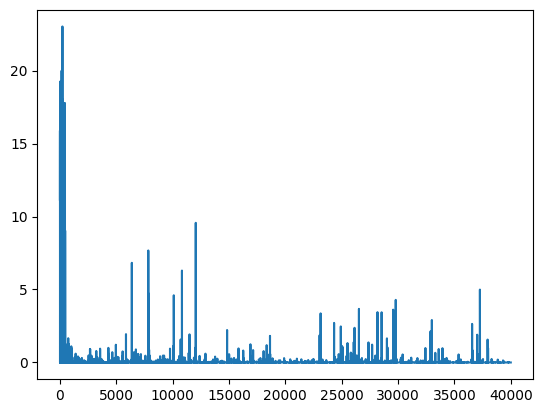

In [211]:
%matplotlib inline
plt.plot(losses)
plt.show()

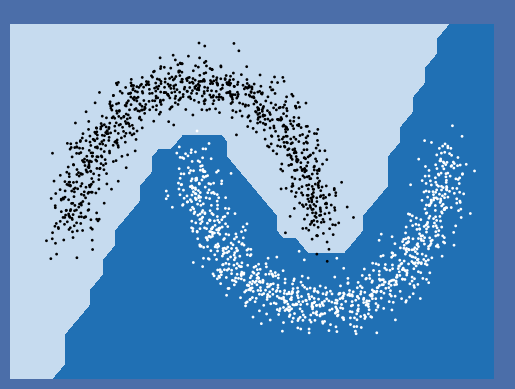

In [212]:
fig, ax = plt.subplots(1, 1, facecolor='#4B6EA9')
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
plot_decision_boundary(ax, X, Y, network)
fig.canvas.draw()

## 3. Using a Pytorch module

In this last part, use `toch.nn.Module` to recode `MyLinear` and `MyReLU` so that these modules will be pytorch compatible.

## 3.1. Load & Preprocess the IMDB Dataset

In this section, you are required to read and load the provided `csv` file, and perform the preprocessing steps as specified in the assignment's description.

In [214]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split

In [215]:
from google.colab import drive
drive.mount('/content/drive')
df=pd.read_csv('/content/drive/MyDrive/imdb_dataset.csv')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [216]:
# df = pd.read_csv('imdb_dataset.csv')

In [217]:
print(len(df))

50000


In [218]:
# Label Encoding for sentiment column
df['sentiment'].replace(['positive', 'negative'],[1,0], inplace = True)

In [219]:
df.head()

review  sentiment
0  One of the other reviewers has mentioned that ...          1
1  A wonderful little production. <br /><br />The...          1
2  I thought this was a wonderful way to spend ti...          1
3  Basically there's a family where a little boy ...          0
4  Petter Mattei's "Love in the Time of Money" is...          1

####Stemming:
The benefits of using the stemming algorithm in an NLP project can be summarised as follows: It reduces the number of words that serve as an input to the Machine Learning/Deep Learning model. It minimizes the confusion around words that have similar meanings. It lowers the complexity of the input space.

####Lemmatization:
Lemmatization is the process of grouping together different inflected forms of the same word. It's used in computational linguistics, natural language processing (NLP) and chatbots.

Lemmatization and Stemming are Text Normalization techniques. These techniques are used to prepare words, text, and documents for further processing.

Languages such as English, Hindi consists of several words which are often derived from one another. Further, Inflected Language is a term used for a language that contains derived words. For instance, word “historical” is derived from the word “history” and hence is the derived word.
There is always a common root form for all inflected words. Further, degree of inflection varies from lower to higher depending on the language.

To sum up, root form of derived or inflected words are attained using Stemming and Lemmatization.

The package namely, nltk.stem is used to perform stemming via different classes. We import PorterStemmer from nltk.stem to perform the above task.

#### TF - IDF:
TF-IDF (Term Frequency-Inverse Document Frequency) is a numerical statistic used in natural language processing and information retrieval to measure the importance of a term in a document within a collection of documents.

The TF part, Term Frequency, measures the frequency of a term (word) in a document. It calculates how often a term appears in a document relative to the total number of terms in that document. This value helps to determine the significance of a term within a specific document.

The IDF part, Inverse Document Frequency, measures the rarity or uniqueness of a term across the entire document collection. It quantifies how important a term is by giving higher weight to terms that appear less frequently in the overall collection of documents. It helps to identify terms that are more informative or distinctive.

TF-IDF is calculated by multiplying the TF value (term frequency) of a term in a document by the IDF value (inverse document frequency) of the term in the entire document collection. This combined value gives a higher score to terms that are both frequent within a document and rare across the entire collection.

The purpose of TF-IDF is to highlight terms that are important and relevant to a particular document while downplaying common terms that appear frequently in many documents. It is commonly used in tasks such as text classification, information retrieval, and document similarity analysis.

In [220]:
import nltk
import re
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [221]:
def preprocess_text(text):
    # Remove special characters and numbers
    text = re.sub('[^a-zA-Z]', ' ', text)

    # Tokenize the text
    tokens = word_tokenize(text)

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word.lower() not in stop_words]

    # Lemmatize the tokens
    # if lemmatize_stemm:
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Stemming
    # else:
      # stemmer = PorterStemmer()
      # stemmed_tokens = [stemmer.stem(token) for token in tokens]

    # Join the tokens back into a single string
    preprocessed_text = ' '.join(tokens)

    return preprocessed_text


In [222]:
df['preprocessed_text'] = df['review'].apply(preprocess_text)

In [223]:
# Separate the comments and labels
# comments = df['review'].values
comments = df['preprocessed_text']
labels = df['sentiment'].values

# Create a TfidfVectorizer with desired settings (3000 features and removing stopwords amd stemming)
vectorizer = TfidfVectorizer(max_features=3000) # tokenizer = tokenize_and_stem

# Tokenize and compute TF-IDF features
features = vectorizer.fit_transform(comments).toarray()

# Normalization on features
normalized_features = normalize(features)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(normalized_features, labels, test_size=0.2, random_state=42)

In [224]:
# Showing one random posotive comment and one random negative comment
import random

# Get indices of positive and negative labels
positive_indices = np.where(labels == 1)[0]
negative_indices = np.where(labels == 0)[0]

# Select random indices for positive and negative comments
random_positive_index = random.choice(positive_indices)
random_negative_index = random.choice(negative_indices)

# Retrieve random positive and negative comments
random_positive_comment = comments[random_positive_index]
random_negative_comment = comments[random_negative_index]

# Print the random comments
print("Random Positive Comment:", random_positive_comment)
print(labels[random_positive_index])
print("Random Negative Comment:", random_negative_comment)
print(labels[random_negative_index])



Random Positive Comment: movie fairly enjoyable watch mean great one better horror movie late seems low almost state benefit budget size charm like lovely lady atmosphere good also missing froma hell lot horror movie day acting typical low budget affair case know dud acting Lucio Fulci movie full like movie atmosphere lacking storyline money etc made horror gore atmosphere movie self br br typical low budget horror movie watchable watched way love horror movie seen movie turn within minute sit fast forward video skip scene DVD movie make want sat watched way end without wanting skip part br br would liked however zombie type folk little scarier scary Freddy Kreuger babysitter seriously though little better would low budget perfection maybe br br music movie top notch stuff ideal horror music seen horror movie music good average could better thank goodness though movie nay Metal music br br die hard Metal fan since horror movie metal music spoil movie loos atmosphere lot type music scor

In [225]:
print(len(X_train))

40000


In [226]:
print(len(X_train[0]))

3000


In [227]:
import matplotlib.pyplot as plt


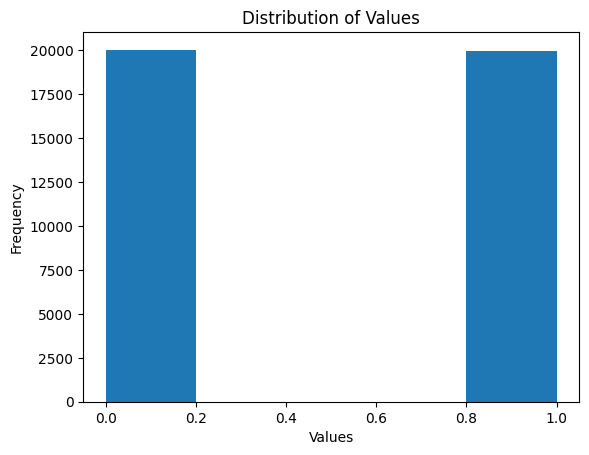

In [228]:
plt.hist(y_train, bins=5)
plt.title('Distribution of Values')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.show()

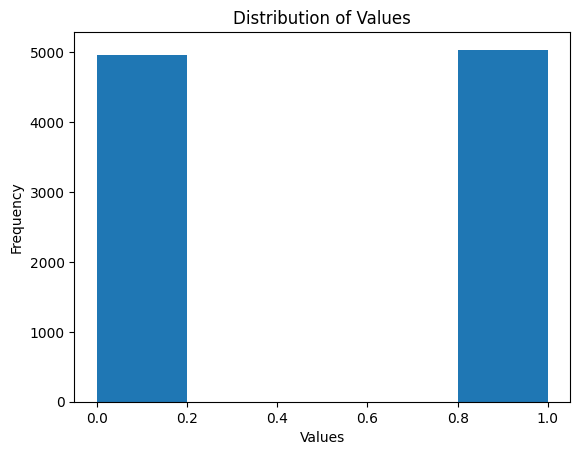

In [229]:
plt.hist(y_test, bins=5)
plt.title('Distribution of Values')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.show()

## 3.2. MLP in torch

In [230]:
import torch
import torch.nn as nn

class MyLinear_mod(nn.Module):
    def __init__(self, n_input, n_output):
        super(MyLinear_mod, self).__init__()
        self.A = nn.Parameter(torch.randn(n_output, n_input))
        self.b = nn.Parameter(torch.randn(n_output))

    def forward(self, x):
        y = torch.matmul(self.A, x.t()) + self.b.unsqueeze(1)
        return y.t()

class MyReLU_mod(nn.Module):
    def __init__(self):
        super(MyReLU_mod, self).__init__()

    def forward(self, x):
        return torch.relu(x)


Define your network using `MyLinear_mod`, `MyReLU_mod` and [`nn.Sigmoid`](https://pytorch.org/docs/stable/nn.html#sigmoid)

In [231]:
n_input = len(X_train[0])
hidden_size = 256
output_size = 1
batch_size = 64
lr = 0.01

In [232]:
# Define your network using MyLinear_mod, MyReLU_mod and nn.Sigmoid
anetwork = nn.Sequential(
    MyLinear_mod(n_input, hidden_size),
    MyReLU_mod(),
    MyLinear_mod(hidden_size, hidden_size),
    MyReLU_mod(),
    MyLinear_mod(hidden_size, output_size),
    nn.Sigmoid()
)
# Define your dataloader here (specify your batch_size)
# Use:
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Note that you should transform your X, y to torch.Tensor

In [233]:
from torch import optim

In [234]:
optimizer = optim.SGD(anetwork.parameters(), lr=lr)
losses = []
criterion = nn.BCELoss()
epochs = 10
for epoch in range(epochs):
    # Train the network
    for batch in train_dataloader:
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        inputs, labels = batch
        outputs = anetwork(inputs)

        # Compute the loss
        loss = criterion(outputs.squeeze(), labels)

        # Backward pass
        loss.backward()

        # Gradient step
        optimizer.step()

        # Track the loss
        losses.append(loss.item())

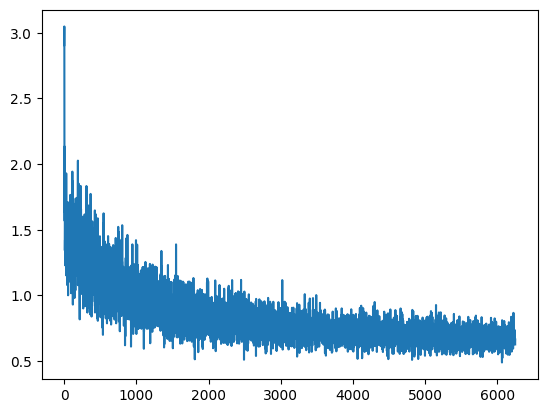

In [235]:
plt.plot(losses)

In [236]:
anetwork.eval()
with torch.no_grad():
    # Evaluation code
    inputs = torch.Tensor(X_test)
    # inputs = torch.Tensor(X_train)

    labels = torch.Tensor(y_test)
    # labels = torch.Tensor(y_train)

    outputs = anetwork(inputs)
predicted_labels = (outputs > 0.5).squeeze().int().tolist()


In [237]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def printResult(y_test, predicted_labels):
  accuracy = accuracy_score(y_test, predicted_labels)
  precision = precision_score(y_test, predicted_labels)
  recall = recall_score(y_test, predicted_labels)
  f1 = f1_score(y_test, predicted_labels)
  print(f"Accuracy: {accuracy}")
  print(f"Precision: {precision}")
  print(f"Recall: {recall}")
  print(f"F1-Score: {f1}")


In [238]:
printResult(y_test, predicted_labels)

Accuracy: 0.6171
Precision: 0.6198494453248812
Recall: 0.6209565389958325
F1-Score: 0.6204024982650936


_____________________________________________________
Batch size:
32.

hidden_size = 128

LR: 0.01

layers:
linear - relu - linear - sigmoid.

Accuracy: 0.651.

Precision: 0.650359153562415.

Recall: 0.6648144473109744.

F1-Score: 0.6575073601570166.

___________________________________________________________
Batch size: 64

hidden_size = 256

LR: 0.01

Layers: linear - relu - linear - relu - linear sigmoid

Accuracy: 0.7426


Precision: 0.703014330423324


Recall: 0.8469934510815638


F1-Score: 0.7683168316831682

Batch size: 128

hidden_size = 256

LR: 0.1

Layers: linear - relu - linear - relu - linear sigmoid

Accuracy: 0.5038

Precision: 0.5038503850385039

Recall: 0.9998015479261758

F1-Score: 0.6700359090304562

## Q1: Training
Best case:

Batch size: 64

hidden_size = 256

LR: 0.01

Layers: linear - relu - linear - relu - linear sigmoid

Accuracy: 0.7241

Precision: 0.6774595267745953

Recall: 0.8636634252827942

F1-Score: 0.7593125708802233

Accuracy: 0.8271
Precision: 0.8412371134020619
Recall: 0.8096844612026196
F1-Score: 0.8251592678733947


## Q2: What happens if all weights are zero?
Initializing all the weights of a neural network to zero causes several problems during training. First, it leads to a symmetry breaking problem where all neurons in a layer have the same values and compute the same output, limiting the network's ability to learn complex patterns. Second, weight update symmetry occurs because the weights remain the same throughout training, preventing the model from learning from the data. Finally, vanishing gradients occur as the gradients become very small, making it difficult for the model to adjust the weights properly.

To overcome these problems, it is crucial to initialize the weights with appropriate strategies, such as random initialization. Random initialization breaks the symmetry and allows each neuron to learn different features. Common techniques include Xavier and He initialization, which use random distributions to assign initial weights. By avoiding all-zero weight initialization, the network can learn effectively from the data.

## Q3: Impact of learning rate:
**Small Learning Rate:**

Slow Convergence: With a very small learning rate, the network takes longer to converge to an optimal solution. The updates to the weights are minimal at each iteration, causing the learning process to progress slowly.
Getting Stuck in Local Minima: When the learning rate is too small, the network may get trapped in local minima and struggle to escape. It becomes difficult for the model to explore the parameter space effectively and find the global minimum.

**Large Learning Rate:**

Divergence: If the learning rate is excessively large, the updates to the weights can become too large as well. This leads to overshooting the optimal solution, causing the loss function to increase rather than decrease. The weights may oscillate or diverge, making the training process unstable.
Failure to Converge: A very large learning rate can prevent the model from converging to an optimal solution. The weights may oscillate around the optimal values without settling down, preventing the network from achieving the desired accuracy or performance.


MyLinear_mod(n_input, hidden_size),
    MyReLU_mod(),
    MyLinear_mod(hidden_size, hidden_size),
    MyReLU_mod(),
    MyLinear_mod(hidden_size, output_size),
    nn.Sigmoid()

n_input = len(X_train[0])
hidden_size = 256
output_size = 1
batch_size = 16

**lr = 0.001**

Accuracy: 0.7101
Precision: 0.6788699431628218
Recall: 0.8059138717999603
F1-Score: 0.7369567189910171

**lr = 0.01**

Accuracy: 0.5039
Precision: 0.5039
Recall: 1.0
F1-Score: 0.6701243433738946

## Q4: Sigmoid and Tanh as hidden layers:
**Vanishing Gradient Problem:** Both sigmoid and tanh functions saturate as the absolute value of the input increases. This means that for large positive or negative inputs, the derivatives of these activation functions approach zero. As a result, during backpropagation, the gradients can become very small, leading to the vanishing gradient problem. The vanishing gradients make it difficult for the network to propagate meaningful error signals to update the weights of earlier layers, limiting the learning capacity of the network.

**Output Range:** Sigmoid function outputs values between 0 and 1, while tanh function outputs values between -1 and 1. This limits the range of activations in the hidden layers, which can affect the learning dynamics of the network. The gradients near the extremes of the output range (i.e., close to 0 or 1 for sigmoid, and -1 or 1 for tanh) are also small, further exacerbating the vanishing gradient problem.

**Non-Zero Centered Output:** The output of sigmoid and tanh functions is not centered around zero. This can introduce biases and affect the convergence speed of the network. It can make the learning process slower and result in longer training times.

Leaky ReLU:

Accuracy: 0.7264

Precision: 0.6754532987962822

Recall: 0.8797380432625521

F1-Score: 0.7641785898982935

tanh:

Accuracy: 0.627

Precision: 0.6271120605942901

Recall: 0.6408017463782496

F1-Score: 0.6338829996073811

sigmoid:
Accuracy: 0.6171

Precision: 0.6198494453248812

Recall: 0.6209565389958325

F1-Score: 0.6204024982650936

## Q4: Leaky ReLU vs ReLU:
The main difference between Leaky ReLU and ReLU is the way they handle negative input values. In ReLU, any negative input is set to zero, effectively "turning off" the neuron. This can cause the neuron to become non-responsive and lead to dead neurons, where they never activate again during training.

Leaky ReLU, on the other hand, allows a small, non-zero gradient for negative input values. It introduces a small slope for negative inputs, typically a small constant value (e.g., 0.01) multiplied by the input. This non-zero slope ensures that the neuron remains active even for negative inputs and can continue to learn and update its weights during training.

The advantage of Leaky ReLU over ReLU is that it mitigates the issue of dead neurons and helps in dealing with the "dying ReLU" problem. By allowing a small gradient for negative inputs, Leaky ReLU enables the network to learn from negative information and recover from situations where some neurons become non-responsive. This can result in better learning and improved model performance.

## Q5: What is the use case of batch? Impacts of too large and too small batch size
**Too Large Batch Size: Disadvantages:** Using a very large batch size can lead to slower convergence and poorer generalization performance. With a large batch size, the model may take longer to converge to an optimal solution because it is making fewer updates to the model parameters per epoch. Additionally, a large batch size can reduce the model's ability to generalize well to unseen data, leading to overfitting. The model may become too specialized to the training data, resulting in lower accuracy on new, unseen examples.

**Too Small Batch Size: Disdvantages:** Using a very small batch size can introduce noise and instability in the training process. With a small batch size, the estimated gradients can be more noisy and less representative of the true gradients of the entire dataset. This noise can make the training process more challenging, as the model parameters may not converge smoothly. Additionally, with a small batch size, the computational efficiency of parallel processing may be diminished, leading to longer training times.

Too Large Batch Size:

**Too Large Batch Size: Advantages:**
Faster computation: Larger batch sizes can take better advantage of parallel processing capabilities of modern hardware, leading to faster training times.
Smoother gradient updates: With more samples in a batch, the computed gradient is more representative of the overall dataset, which can lead to smoother updates of the model weights.


**Too Small Batch Size: Advantages:**
Lower memory requirements: Smaller batch sizes require less memory, allowing for training on devices with limited resources.
Potentially better generalization: Smaller batch sizes can introduce more noise into the gradient estimation, which may help the model escape sharp minima and generalize better.


n_input = len(X_train[0])

hidden_size = 256

output_size = 1

lr = 0.01

**batch_size = 16**

Accuracy: 0.8024

Precision: 0.7824082611100867

Recall: 0.8420321492359595

F1-Score: 0.8111259797361882
____________________________________________________________
**batch_size = 256**

Accuracy: 0.6639

Precision: 0.6283267054144999

Recall: 0.8152411192696963

F1-Score: 0.7096829921395871